In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','crossref/cermine')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/crossref/cermine/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [5]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/glove-300.matrix.npy',
                        text_columns = ['author', 'title', 'journal'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'unscaled_inverse_lp', 'scaled_inverse_lp'],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        lstm_args=dict(units=25, dropout=0, recurrent_dropout=0),
                        batch_norm=True,
                        dropout=0.5)

W0722 17:13:16.207180  6488 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 17:13:16.537807  6488 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 17:14:28.380667  6488 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 17:14:29.227595  6488 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 17:14:29.235519  6488 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 92


W0722 17:14:54.573374  6488 deprecation.py:506] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Crash recovery 

In [15]:
model.load_weights('../data/models/crossref-cermine-base-2-num-null')
df_hist = pd.read_csv('../data/histories/crossref-cermine-base-2-num-null.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 1728716 samples, validate on 216089 samples
Epoch 1/1
1728716/1728716 [==============================] - 61181s 35ms/step - loss: 0.3512 - acc: 0.8980 - val_loss: 0.0558 - val_acc: 0.9979


# Learning curves

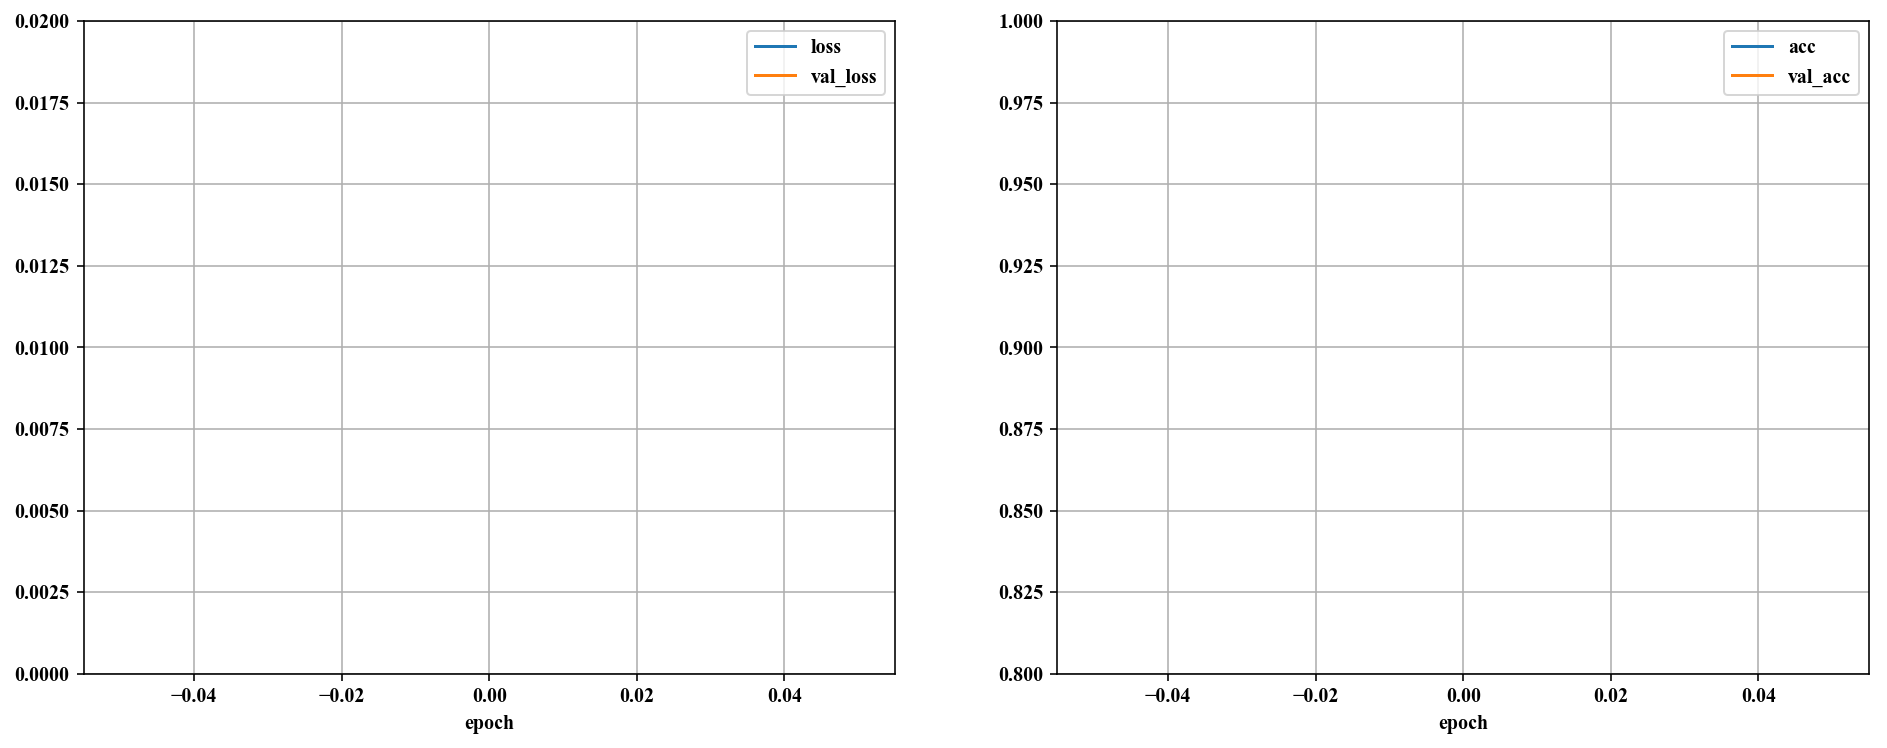

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.8, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [10]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213859
           1       0.97      0.82      0.89      2230

   micro avg       1.00      1.00      1.00    216089
   macro avg       0.98      0.91      0.94    216089
weighted avg       1.00      1.00      1.00    216089

[[213800     59]
 [   399   1831]]


In [12]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['author', 'title', 'journal']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,author,title,journal,year,id2,author,title,journal,year
212724,3f802e90-abdf-11e9-a7ec-04ea56df376a,Modelagem <unk> na <unk> do campo : <unk> de <unk> locais / Mathematical modeling in rural education : visibility of local knowledge,"Magnus , M. C. M.",Cadernos <unk>,2018.0,3f7ef662-abdf-11e9-8b6a-04ea56df376a,"Modelagem <unk> na <unk> do campo : <unk> de <unk> locais / Mathematical modeling in rural education : visibility of local <unk> ( , 8 : 1 Cadernos <unk> 391",Magnus,<unk>,2018.0
97829,42793912-abdf-11e9-928c-04ea56df376a,<unk> Chromosomal Proteins,<unk>,<unk>,1982.0,427a7664-abdf-11e9-a26d-04ea56df376a,<unk>,Anon,"The Chromosomal Proteins , org / 10.1016 / <unk>",1982.0
25214,4251eefe-abdf-11e9-92f8-04ea56df376a,Viscous Effects in Plasma Acceleration,"Kumar , P.V.",47th AIAA Aerospace Sciences Meeting including The New Horizons Forum and Aerospace <unk> ( Jan,2009.0,42548c68-abdf-11e9-aa7c-04ea56df376a,<unk>,"Kumar , P. V. , Nagendra , B. , Sheshadri , T. , Kadal , H. K.",Viscous Effects in Plasma <unk> 47th AIAA Aerospace Sciences Meeting Including The New Horizons Forum and Aerospace <unk> doi : <unk> / 6,2009.0
148029,47a3aa22-abdf-11e9-b4bb-04ea56df376a,<unk>,"<unk> Der <unk> Monarchie , <unk> , Crossref",Nature,1885.0,47a58a98-abdf-11e9-b3e3-04ea56df376a,<unk> <unk> der <unk> <unk> (,<unk>,<unk>,1885.0
117806,48c67318-abdf-11e9-be81-04ea56df376a,<unk>,"<unk> , Giaretta","Philosophia [ online ] . 20 December 2017 , <unk> 2 , <unk> <unk>",2017.0,48c48b82-abdf-11e9-8051-04ea56df376a,<unk>,<unk>,<unk>,2017.0


# Save model and histories 

In [13]:
pd.DataFrame(histories).to_csv('../data/histories/crossref-cermine-base-2-num-null.csv', index=False)
model.save_weights('../data/models/crossref-cermine-base-2-num-null')

# Test model 

In [14]:
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99828   0.99965   0.99897    214015
           1    0.95843   0.82217   0.88508      2075

   micro avg    0.99795   0.99795   0.99795    216090
   macro avg    0.97835   0.91091   0.94203    216090
weighted avg    0.99790   0.99795   0.99787    216090

[[213941     74]
 [   369   1706]]
